In [1]:
import glob
import numpy as np
import pandas as pd
import cv2
from hand_tracker import HandTracker

In [2]:
# Models to find hands and hand keypoints
PALM_MODEL_PATH = "./models/palm_detection_without_custom_op.tflite"
LANDMARK_MODEL_PATH = "./models/hand_landmark.tflite"
ANCHORS_PATH = "./models/anchors.csv"
detector = HandTracker(
    PALM_MODEL_PATH,
    LANDMARK_MODEL_PATH,
    ANCHORS_PATH,
    box_shift=0.2,
    box_enlarge=1.3
)

In [3]:
# Load image, run hand keypoint detection.
# Do these steps for the vertically mirrored image also.
def collect_data(data_list, label_list, label, path):
    for file in glob.glob(path):
        # Noraml image
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        points, box = detector(img)
        if points is not None:
            data_list.append(np.array(points.flatten()))
            label_list.append(label)
        else:
            #print('Hand or hand keypoint detection error on normal image')
            pass

        # Vertically mirrored image
        points, box = detector(np.fliplr(img))
        if points is not None:
            data_list.append(np.array(points.flatten()))
            label_list.append(label)
        else:
            #print('Hand or hand keypoint detection error on mirrored image')
            pass

In [4]:
# Collect data for training
x = []
y = []
collect_data(x, y, 0, 'collection/misc/*.png')
collect_data(x, y, 1, 'collection/metal/*.png')
collect_data(x, y, 2, 'collection/peace/*.png')
collect_data(x, y, 3, 'collection/stop/*.png')
collect_data(x, y, 4, 'collection/ok/*.png')

C:\Users\admin\Desktop\handsign projekt\hand_tracker.py:95: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x) )


In [5]:
## Augment data

print('Number of train samples before augmentation', len(x) / 2)

# Mirror / Flip vertically (done during train set assembly)

# Translation
for i in range(len(x)):
    for j in range(20):
        x_offset = np.random.randint(640) - 320
        y_offset = np.random.randint(480) - 240
        offset = [x_offset, y_offset] * 21
        x.append(x[i] + offset)
        y.append(y[i])
        
# Create new samples with keypoint(joint) coordinate noise
for i in range(len(x)):
    for j in range(20):
        offset = [0] * 42
        index = np.random.randint(420)
        if index < 42:
            offset[index] = np.random.randint(20) - 10
            
        x.append(x[i] + offset)
        y.append(y[i])
        
print('Number of train samples after augmentation', len(x))

Number of train samples before augmentation 1336.5
Number of train samples after augmentation 1178793


In [6]:
# Calculate class weights
x = np.array(x)
y = np.array(y)

class_weight = len(y) / (np.bincount(y).shape[0] * np.bincount(y))
print('Number of samples in each class:', np.bincount(y))
print('Class weights:', class_weight)

Number of samples in each class: [381465 175077 160524 332955 128772]
Class weights: [0.61803468 1.3465995  1.46868132 0.70807947 1.83082192]


In [7]:
# One-hot encode labels
def one_hot_encode(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape) + [nb_classes])

y_train = one_hot_encode(y, 5)

In [8]:
# Shuffle samples 
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train, y_train = unison_shuffled_copies(x, y_train)

In [9]:
# Normalization
# Only rough normalization, keypoint max could be bigger than image shape along x axis because of augmentation
x_train = x_train / x_train.max() - 0.5

In [10]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, GaussianDropout, Dropout,  Activation, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

In [11]:
# Rough estimation about the number of neurons in a 3 layer NN, Part 1
input_neurons = 42 # Usually the size of your input
output_size = 5
factor = 10 # Unaugmented data: 1..5. (consider: noise augmentation has small amount of new information)
samples = 0.8 * x_train.shape[0]
hidden_neurons = int(np.ceil(samples / (factor * (input_neurons + output_size))))
print('Input neurons:', input_neurons)
print('Estimation about ideal number of hidden neurons:',hidden_neurons)

Input neurons: 42
Estimation about ideal number of hidden neurons: 2007


In [12]:
# Rough estimation about the number of neurons in a 3 layer NN, Part 2
# First layer is a combination of coordinates.
# Absolute coordinates and sistances between keypoints are needed for the hidden layer.
# Keypoints have ~2 keypoint neighbor. This implies the need for 3*input shape but 4*input shape has higher accuracy.
input_neurons = 4*42
output_size = 5
factor = 10 # Unaugmented data: 1..5. (consider: noise augmentation has small amount of new information)
samples = 0.8 * x_train.shape[0]
hidden_neurons = int(np.ceil(samples / (factor * (input_neurons + output_size))))
print('Input neurons:', input_neurons)
print('Estimation about ideal number of hidden neurons:', hidden_neurons)

Input neurons: 168
Estimation about ideal number of hidden neurons: 546


In [13]:
# Best combination was relu/adam
activation = 'relu' # relu / tfa.activations.mish
drop_rate = 0.5

x1 = Input(shape=(42,))

x2 = Dense(input_neurons, activation=activation) (x1) # 84
x2 = Dropout(drop_rate) (x2)

x3 = Dense(hidden_neurons, activation=activation) (x2) #458
x3 = Dropout(drop_rate) (x3)

x4 = Dense(5, activation='softmax') (x3)

model = Model(inputs=x1, outputs=x4)

radam = tfa.optimizers.RectifiedAdam()
ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
model.compile(loss = "categorical_crossentropy", optimizer='adam', metrics=["acc"])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 42)]              0         
_________________________________________________________________
dense (Dense)                (None, 168)               7224      
_________________________________________________________________
dropout (Dropout)            (None, 168)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 546)               92274     
_________________________________________________________________
dropout_1 (Dropout)          (None, 546)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2735      
Total params: 102,233
Trainable params: 102,233
Non-trainable params: 0
_______________________________________________________

Train on 943034 samples, validate on 235759 samples
Epoch 1/14
942336/943034 [============================>.] - ETA: 0s - loss: 0.4049 - acc: 0.8488
Epoch 00001: val_acc improved from -inf to 0.91043, saving model to models/model.h5
943034/943034 [==============================] - 25s 27us/sample - loss: 0.4048 - acc: 0.8488 - val_loss: 0.2339 - val_acc: 0.9104
Epoch 2/14
942336/943034 [============================>.] - ETA: 0s - loss: 0.2687 - acc: 0.8989
Epoch 00002: val_acc improved from 0.91043 to 0.93052, saving model to models/model.h5
943034/943034 [==============================] - 23s 24us/sample - loss: 0.2687 - acc: 0.8989 - val_loss: 0.1735 - val_acc: 0.9305
Epoch 3/14
942336/943034 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9119
Epoch 00003: val_acc improved from 0.93052 to 0.93890, saving model to models/model.h5
943034/943034 [==============================] - 22s 23us/sample - loss: 0.2328 - acc: 0.9119 - val_loss: 0.1563 - val_acc: 0.9389
Epoch 

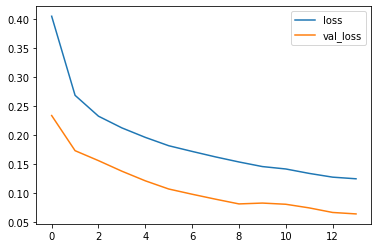

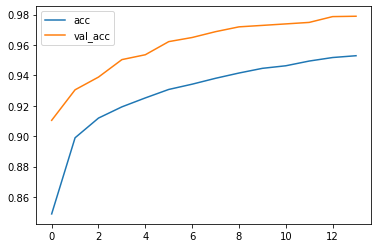

In [14]:
# Train
checkpoint = ModelCheckpoint('models/model.h5',
                             monitor='val_acc',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='max')
history = model.fit(x_train, y_train, batch_size=256, epochs=14,
                    validation_split=0.2, class_weight=class_weight,
                    verbose=1, callbacks=[checkpoint])
    
# Save data
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()